In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

%cd /content/drive/MyDrive/images

!ls

/content/drive/MyDrive/images
color_image_48.jpg  color_image_50.jpg	color_image_52.jpg  color_image_54.jpg
color_image_49.jpg  color_image_51.jpg	color_image_53.jpg


In [10]:
# Load the LRV file into a Python script using a video processing library like OpenCV.

# Extract the frames from the video sequence and process them individually.

# Use a computer vision algorithm to detect cars in each frame. You could use a pre-trained object detection model like YOLO or Faster R-CNN to perform this task. Alternatively, you could use a feature-based approach like Haar cascades or HOG-SVM to detect cars.

# For each car detected in a frame, extract the region of interest (ROI) around the car and apply optical flow algorithms to estimate the motion between two consecutive frames. You can use PyTorch Optical Flow library or any other optical flow library of your choice.

# Calculate the magnitude of the optical flow vectors for the ROI. If the magnitude is above a certain threshold, then the car is moving. If it is below the threshold, then the car is stationary.

# Repeat this process for all the frames in the video sequence.

# Use the results to classify each car in the video as moving or stationary.



!pip install torch torchvision opencv-python numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
%pwd
!ls -a

# %cd /content/images
# !ls -a


color_image_48.jpg  color_image_50.jpg	color_image_52.jpg  color_image_54.jpg
color_image_49.jpg  color_image_51.jpg	color_image_53.jpg


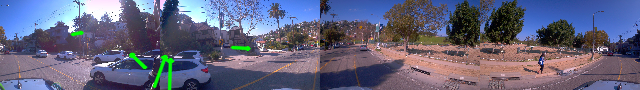

In [22]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models import detection
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import time
from IPython.display import clear_output, display
from PIL import Image
import io
import os

# Load the pre-trained car detection model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the Lucas-Kanade parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def resize_image(image, max_size=640):
    height, width = image.shape[:2]
    scale_factor = max_size / max(height, width)
    if scale_factor < 1:
        new_size = (int(width * scale_factor), int(height * scale_factor))
        image = cv2.resize(image, new_size)
    return image


def detect_cars(image):
    with torch.no_grad():
        transform = T.Compose([T.ToTensor()])
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        output = model(input_batch)
        boxes = output[0]["boxes"].numpy()
        scores = output[0]["scores"].numpy()

        # Filter boxes with a confidence score above 0.5
        boxes = boxes[scores >= 0.5]

    return boxes

def track_cars(prev_gray, next_gray, prev_points):
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_points, None, **lk_params)
    status = status.ravel().astype(bool)
    moved_points = next_points[status]
    prev_points = prev_points[status]

    return prev_points, moved_points



def process_images(image_files):
    prev_gray = None
    prev_points = None

    # for img_path in image_files:
    #     image = cv2.imread(img_path)
    #     if image is None:
    #         print(f"Error loading image: {img_path}")
    #         continue

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img_path in enumerate(image_files):
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image: {img_path}")
            continue
        image = resize_image(image)  # Add this line to resize the image

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if prev_gray is None:
            prev_gray = gray
            boxes = detect_cars(image)
            prev_points = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes], dtype=np.float32)
            continue

        prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
        movement = moved_points - prev_points

        for i, (prev, next) in enumerate(zip(prev_points, moved_points)):
            a, b = next.ravel().astype(int)
            c, d = prev.ravel().astype(int)
            dist = np.linalg.norm(next - prev)

            # Change this threshold value to adjust the sensitivity of movement detection
            if dist > 2:
                cv2.arrowedLine(image, (a, b), (c, d), (0, 255, 0), 2, cv2.LINE_AA)

        # cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow
        # cv2.waitKey(500)  # Wait for 500 ms before showing the next frame
        # clear_output(wait=True)

        prev_gray = gray

        # Convert the image from BGR to RGB format and display it using IPython.display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(image))
        time.sleep(0.5)  # Wait for 500 ms before showing the next frame
        clear_output(wait=True)

    cv2.destroyAllWindows()

output_folder = "content/drive/MyDrive/ARROW_FILES"    

# Replace the list with your own sequence of image files
image_files = ["color_image_48.jpg", "color_image_49.jpg", "color_image_50.jpg", "color_image_51.jpg", "color_image_52.jpg", "color_image_53.jpg", "color_image_54.jpg"]
process_images(image_files)
